# Low-Rank Approximation

In this section, you will be asked to investigated how the trade-off between
the selected ranks of SVD and its performance in terms of reconstruction
accuracy and speed-up (in clock-time and in FLOPS).

## 1. Set-up

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a4-NamanMakkar' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a4-NamanMakkar
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Verify the following cell prints your github repository.

In [13]:
!ls {PROJECT_ROOT}

 1-numerical_precision.ipynb
 2-svd_rank.ipynb
 compression_ratio_vs_acc_and_runtime.png
 compression_ratio_vs_acc.png
 compression_ratio_vs_runtime.png
 data
 errors_plot.png
 fft_reconstruction_loss.png
'for a batch of MNIST data.png'
'for a random matrix.png'
'for intermediate activation of Fully connected network.png'
'for Pixels of cat.png'
'for weight matrix of fully connected network.png'
 low_rank_data.pickle
 mnist.py
 ranks_vs_flops_runtime_speedup.png
 rank_vs_flops.png
 rank_vs_flops_speedup.png
 rank_vs_runtime.png
 rank_vs_runtime_speedup.png
 README.md
 reconstruction_error_extra_creidt_logmatmul.png
 reconstruction_error_logmatmul.png
 src
 tests
 winograd_reconstruction_loss.png


In [6]:
# Install required packgaes
!pip install torch numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Rank v.s. Reconstruction Error

In this following cell(s), please plot the number of ranks preserved for A matrix (in the x-axis)
and the reconstruction error of the matrix (in the y-axis, measured by the Frobenius Norm).

NOTE: you can use `svd(A, torch.eye(A.shape(2), rank_A=<rank>, rank_B=None)` to do SVD, drop the rank
to `<rank>`, and return the reconstruction matrix of `A`.

We will provide a series of matrix for you to study. Please make one plot per matrix.
For each plot, comment on the trade-off between the number of ranks selected and the error by answering
the following questions:
1. Is the reconstruction error increasing or decreasing as we add more rank?
2. How fast is the reconstruction error change as we add more rank? Is it changing quickly or slowly? Why?
3. Is there a rank number below/above which the reconstruction error increase significantly?
4. What can you learn about this data?

In [7]:
%cd {PROJECT_ROOT}

/content/gdrive/MyDrive/ece5545/a4-NamanMakkar


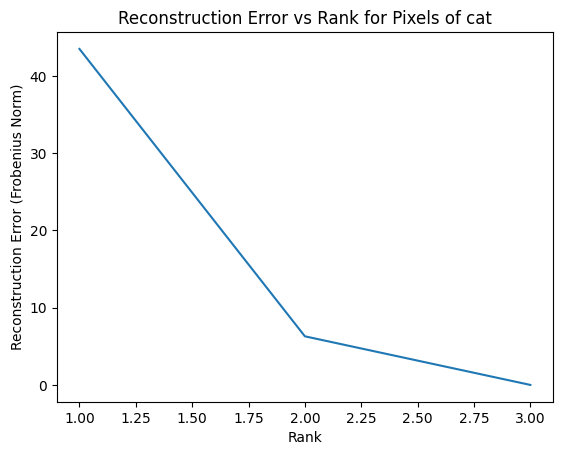

In [8]:
from src.matmul import svd
import torch
import matplotlib.image
import matplotlib.pyplot as plt
# Pixels of a cute cat
A = torch.from_numpy(matplotlib.image.imread("data/cat.png")).view(-1, 3)

def reconstruction_error(true, pred):
  return torch.norm(true - pred, p='fro').item()

def error_vs_rank(matrix, max_rank, task='for Pixels of cat'):
    rank_values = list(range(1, max_rank + 1))
    errors = []

    for rank in rank_values:
        reconstructed_matrix = svd(matrix, torch.eye(matrix.shape[1]), rank_A=rank, rank_B=None)
        error = reconstruction_error(matrix, reconstructed_matrix)
        errors.append(error)
    fig = plt.figure()
    plt.plot(rank_values, errors)
    plt.xlabel('Rank')
    plt.ylabel('Reconstruction Error (Frobenius Norm)')
    plt.title(f'Reconstruction Error vs Rank {task}')
    fig.savefig(f'{task}.png')
    plt.show()
max_rank = min(A.shape)
error_vs_rank(A, max_rank)

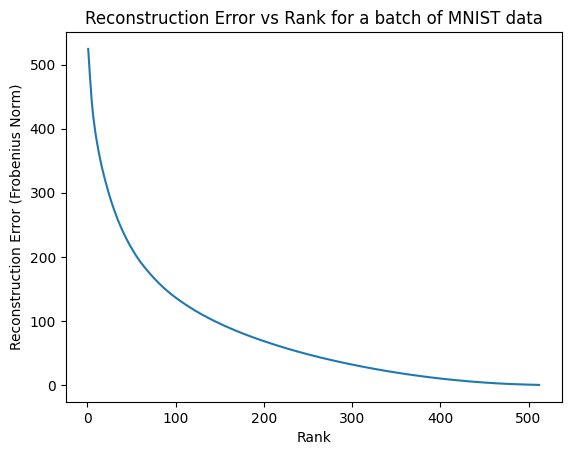

In [9]:
# A batch of MNIST digit
import torch
A = torch.load("data/mnist_act.pt")['act.0']
max_rank = min(A.shape)
error_vs_rank(A, max_rank, task='for a batch of MNIST data')

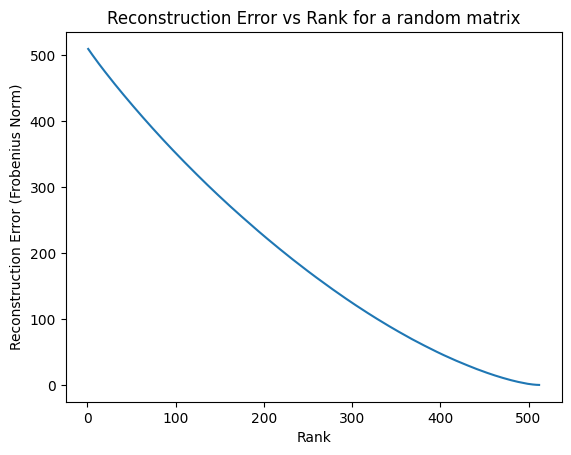

In [10]:
import torch
# A random matrix
A = torch.randn(512, 512)
max_rank = min(A.shape)
error_vs_rank(A, max_rank, task='for a random matrix')

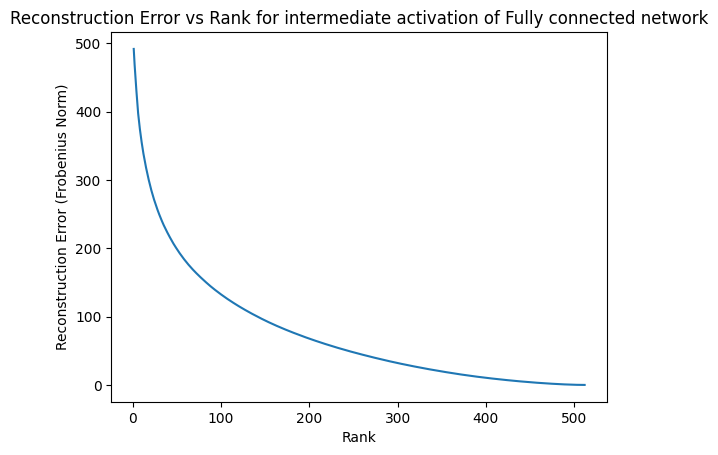

In [11]:
import torch
# Intermediate activation of a Fully connected network (trained on MNIST)
A = torch.load("data/mnist_act.pt")['act.1']
max_rank = min(A.shape)
error_vs_rank(A, max_rank, task='for intermediate activation of Fully connected network')

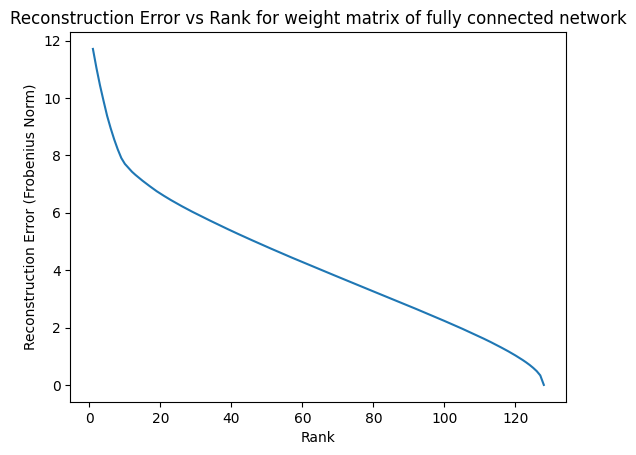

In [12]:
import torch
# Weight matrix of a fully connected neural network (trained on MNIST)
A = torch.load("data/mnist_fc.pt")['fc2.weight']
max_rank = min(A.shape)
error_vs_rank(A, max_rank, task='for weight matrix of fully connected network')

# 2. Rank v.s. Speed up

In this following cell(s), please plot the number of ranks preserved for A matrix (in the x-axis)
and the speed up of matrix-matrix multiply (in the y-axis, measured by both FLOPs and clock time)

You can assume both matrix A and B are using the same number of rank when approximating.

In [15]:
import torch
import time
# Intermediate activation of a Fully connected network (trained on MNIST)
A = torch.load("data/mnist_act.pt")['act.1']

# Weight matrix of a fully connected neural network (trained on MNIST)
B = torch.load("data/mnist_fc.pt")['fc2.weight'].transpose(0, 1)

device = 'cuda'

def matmul_time(A, B):
  start = time.time()
  torch.matmul(A,B)
  end = time.time()
  return end - start

def calc_svd_flops(A, B, rank):
  return (A.shape[0] * rank * A.shape[1]) + (B.shape[0] * rank * B.shape[1])

def rank_vs_speedup(A, B, max_rank):
  ranks = list(range(1,max_rank+1))
  A = A.to(device)
  B = B.to(device)
  time_speedup = []
  rank_runtimes = []
  rank_flops = []
  flops_speedup = []
  original_runtime = matmul_time(A, B)
  original_flops = A.shape[0] * A.shape[1] * B.shape[1] # FLOPS of matmul = Big-O complexity of matrix multiplication

  for rank in ranks:
    start = time.time()
    AB_approx = svd(A, B, rank_A = rank, rank_B = rank)
    end = time.time()

    runtime_approx = end - start
    rank_runtimes.append(runtime_approx)

    flops_approx = calc_svd_flops(A,B,rank)
    rank_flops.append(flops_approx)

    flops_speedup.append(original_flops/flops_approx)
    time_speedup.append(original_runtime/runtime_approx)

    torch.cuda.empty_cache()
  return ranks, time_speedup, rank_runtimes, flops_speedup, rank_flops


ranks, time_speedup, runtimes, flops_speedup, flops = rank_vs_speedup(A, B, min(A.shape[1], B.shape[0]))

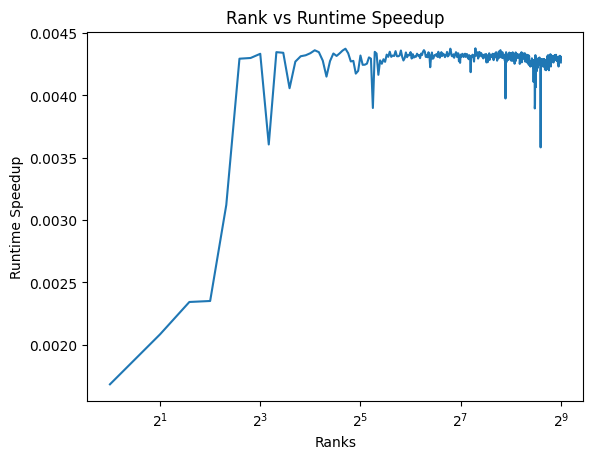

In [20]:
fig = plt.figure()
plt.plot(ranks, time_speedup)
plt.xlabel('Ranks')
plt.xscale('log', base=2)
plt.ylabel('Runtime Speedup')
plt.title('Rank vs Runtime Speedup')
fig.savefig('rank_vs_runtime_speedup.png')
plt.show()

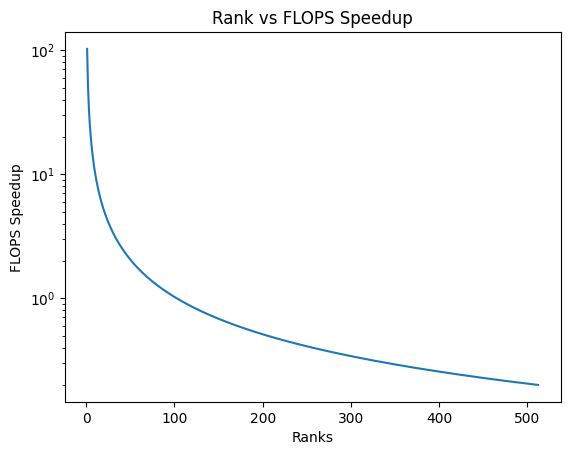

In [21]:
fig = plt.figure()
plt.plot(ranks, flops_speedup)
plt.yscale('log', base=10)
plt.xlabel('Ranks')
plt.ylabel('FLOPS Speedup')
plt.title('Rank vs FLOPS Speedup')
fig.savefig('rank_vs_flops_speedup.png')
plt.show()

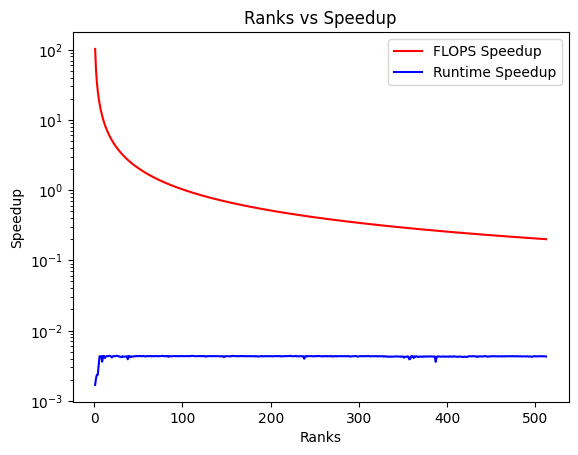

In [19]:
fig = plt.figure()
plt.plot(ranks, flops_speedup, 'r', label="FLOPS Speedup")
plt.plot(ranks, time_speedup, 'b', label='Runtime Speedup')
plt.yscale('log',base=10)
plt.xlabel('Ranks')
plt.ylabel('Speedup')
plt.title('Ranks vs Speedup')
plt.legend()
fig.savefig('ranks_vs_flops_runtime_speedup.png')
plt.show()